# Example 2: Fault correlation through time steps of 2-D numerical model
This example describes how to correlate faults extracted at different time steps.

## Setup

1. First, you will need sign in to your Google account. If you're not signed in, you can sign in [here](https://myaccount.google.com/?utm_source=sign_in_no_continue)
2. Next, head on to the [Colab Welcome Page](https://colab.research.google.com/notebooks/welcome.ipynb#recent=true).
3. There, select Github in the top tab and search for https://github.com/thilowrona/fault_analysis_toolbox/blob/master/examples/2-fault_properties/2-fault_properties.ipynb
4. Clicking opens this notebook. This is a Jupyter notebook; an awesome combination of code and documentation allowing us work on, describe and share our projects.
5. When you run the first cell, you will face a pop-up saying ‘Warning: This notebook was not authored by Google’; you should click on ‘Run Anyway’ to get rid of the warning.
6. Next we want to save our notebook. If you click on ‘File’ and then ‘Save’, you will see a pop-up saying ´CANNOT SAVE CHANGES´. Now, click on ‘SAVE A COPY IN DRIVE’. This opens up a new tab with the same file, but this time located in your Drive. If you want to continue working after saving, use the file in the new tab. Your notebook will be saved in a folder called Colab Notebooks in your Google Drive by default.

## Load packages
To run the toolbox, we will need a couple of packages including the toolbox itself. So let's install them:

In [ ]:
!git clone https://github.com/thilowrona/fault_analysis_toolbox

Cloning into 'fault_analysis_toolbox'...
remote: Enumerating objects: 174, done.
remote: Counting objects: 100% (174/174), done.
remote: Compressing objects: 100% (171/171), done.
remote: Total 1929 (delta 99), reused 0 (delta 0), pack-reused 1755
Receiving objects: 100% (1929/1929), 330.06 MiB | 23.06 MiB/s, done.
Resolving deltas: 100% (331/331), done.
Checking out files: 100% (1389/1389), done.


In [ ]:
!pip3 install vtk
!pip3 install git+https://github.com/ulikoehler/cv_algorithms.git

     |████████████████████████████████| 103.4MB 51kB/s 
  Cloning https://github.com/ulikoehler/cv_algorithms.git to /tmp/pip-req-build-ll7uu_lr
  Running command git clone -q https://github.com/ulikoehler/cv_algorithms.git /tmp/pip-req-build-ll7uu_lr
  Created wheel for cv-algorithms: filename=cv_algorithms-1.0.0-cp36-cp36m-linux_x86_64.whl size=43504 sha256=bbdaadc5af6daecb9fe59ef0baf80dc44cce0b2bb9a9b2f4f8a32590de827253
  Stored in directory: /tmp/pip-ephem-wheel-cache-dsf3qowt/wheels/0b/45/f6/dfa0d535f50a0148a4c7d6912942fdb7a6445d7196a2591cbe
Successfully built cv-algorithms


Now we can load the python packages:

In [ ]:
import numpy as np 
import networkx as nx
import pickle

import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix

from sys import stdout

and the functions from the fault analysis toolbox that we want to use:

In [ ]:
import sys
sys.path.append('/content/fault_analysis_toolbox/code/')

from image_processing import guo_hall
from edits import *
from metrics import *
from plots import *

## Fault extraction

First, we load our fault networks extracted from a 2-D model at two consecutive timesteps:

In [ ]:
G_60 = pickle.load(open('/content/fault_analysis_toolbox/examples/2-time_stepping/g_60.p', 'rb'))          
G_61 = pickle.load(open('/content/fault_analysis_toolbox/examples/2-time_stepping/g_61.p', 'rb'))  

Now we can visualize and compare the faults extracted at both time steps:

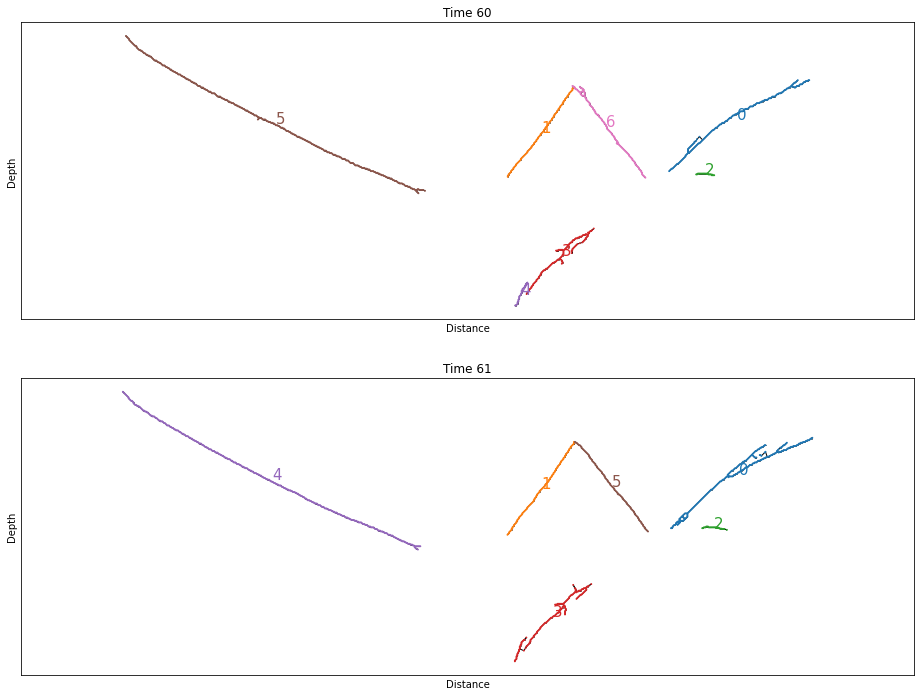

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(16,12))

plot_components(G_60, axs[0], label=True)
axs[0].set_ylim(axs[0].get_ylim()[::-1])
axs[0].axis('equal')
axs[0].get_xaxis().set_ticks([])
axs[0].get_yaxis().set_ticks([])
axs[0].set_title('Time 60')
axs[0].set_xlabel('Distance')
axs[0].set_ylabel('Depth')

plot_components(G_61, axs[1], label=True)
axs[1].set_ylim(axs[1].get_ylim()[::-1])
axs[1].axis('equal')
axs[1].get_xaxis().set_ticks([])
axs[1].get_yaxis().set_ticks([])
axs[1].set_title('Time 61')
axs[1].set_xlabel('Distance')
axs[1].set_ylabel('Depth')

plt.show()

Now we want to correlate the faults between time steps. To do this, we define another graph (H), where each fault is a node and each successful correlation is an edge. But first, the nodes:

In [ ]:
G_60 = compute_edge_length(G_60)
G_61 = compute_edge_length(G_61)  
   

H = nx.DiGraph()

def H_add_pairs(H, G, step):       
    for component in sorted(nx.connected_components(G)):
        for node in component:
            pair = (step, G.nodes[node]['component']) # timesteps & components
            H.add_node(pair)
            H.nodes[pair]['pos'] = pair
            H.nodes[pair]['component'] = pair[1]
            H.nodes[pair]['length'] = total_length(G.subgraph(component)) # cannot be zero for plotting
            break
    return H

# Add two time steps
H = H_add_pairs(H, G_60, 60)    
H = H_add_pairs(H, G_61, 61)    


Now let's look at it:

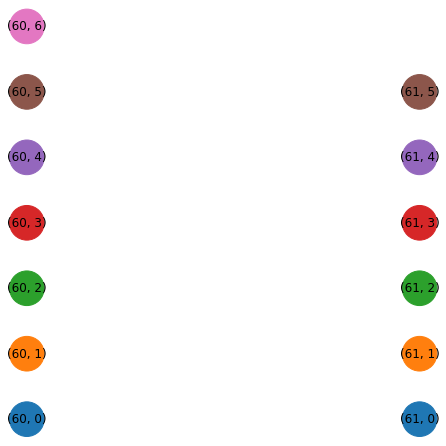

In [ ]:
plt.figure(figsize=(6,6))
nx.draw(H,
        pos = nx.get_node_attributes(H, 'pos'),
        with_labels=True,
        node_color = get_node_colors(H, 'component'),
        node_size = 1200)
plt.show()

So let's do the correlation! First, we convert all the components to point sets:

In [ ]:
components_60 = get_components(G_60)
components_61 = get_components(G_61)
        
def components_to_points(G, components):
    point_set = []
    for cc in sorted(nx.connected_components(G)):    
        points = []
        for node in cc:
            points.append(G.nodes[node]['pos'])    
        point_set.append(points)
    return point_set
    
    
pt_set_60 = components_to_points(G_60, 'all')
pt_set_61 = components_to_points(G_61, 'all')

Now we check if the points sets lie within each other:

In [ ]:
def is_A_in_B(set_A, set_B, R):    
      
    distances = distance_matrix(set_A, set_B)
              
    if np.mean(np.min(distances, axis=1)) > R:
        return False
    else:
        return True
      

                    
R = 10 # Minimum radius

connections = set()
for cp_60, pts_60 in zip(components_60, pt_set_60):
    for cp_61, pts_61 in zip(components_61, pt_set_61):
        if is_A_in_B(pts_60, pts_61, R):
            connections.add((cp_60, cp_61))
        if is_A_in_B(pts_61, pts_60, R):
            connections.add((cp_60, cp_61))
    

Now you can add the edges to the H-graph:

In [ ]:
for connection in connections:
    H.add_edge((60, connection[0]), (61, connection[1]))

To make sure that the label of the largest fault is preserved, we propagate labels in ascending order (from small to large) and sorted by fault length (so the large one take over the small ones):

In [ ]:
step = 60
   
edges = [edge for edge in H.edges() if edge[0][0]==step]
lengths = [H.nodes[edge[0]]['length'] for edge in H.edges() if edge[0][0]==step]    
lengths, edges = zip(*sorted(zip(lengths, edges))) # sort simultaneously

for edge in edges:
    H.nodes[edge[1]]['component'] = H.nodes[edge[0]]['component'] 

Let's check out the result

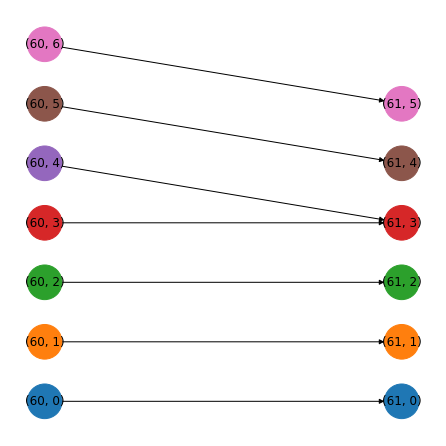

In [ ]:
plt.figure(figsize=(6,6))
nx.draw(H,
        pos = nx.get_node_attributes(H, 'pos'),
        with_labels=True,
        node_color = get_node_colors(H, 'component'),
        node_size = 1200)
plt.show()

So let's relabel and check if it worked:

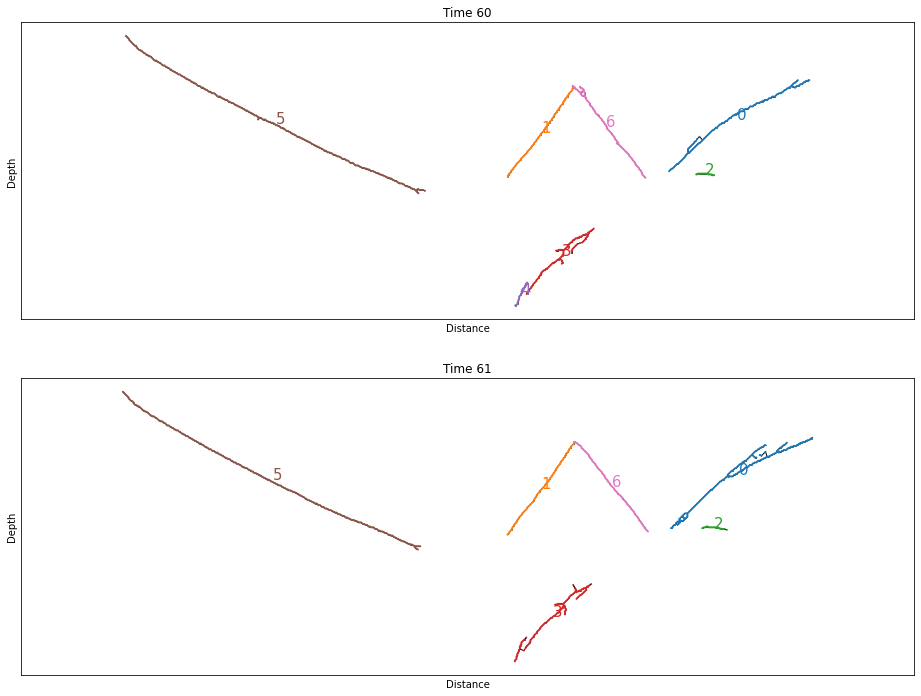

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(16,12))

plot_components(G_60, axs[0], label=True)
axs[0].set_ylim(axs[0].get_ylim()[::-1])
axs[0].axis('equal')
axs[0].get_xaxis().set_ticks([])
axs[0].get_yaxis().set_ticks([])
axs[0].set_title('Time 60')
axs[0].set_xlabel('Distance')
axs[0].set_ylabel('Depth')

plot_components(G_61, axs[1], label=True)
axs[1].set_ylim(axs[1].get_ylim()[::-1])
axs[1].axis('equal')
axs[1].get_xaxis().set_ticks([])
axs[1].get_yaxis().set_ticks([])
axs[1].set_title('Time 61')
axs[1].set_xlabel('Distance')
axs[1].set_ylabel('Depth')

plt.show()